In [131]:
#imports for data manipulation/visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [132]:
# read in data from csv file, don't need the date column so will remove
df = pd.read_csv('ml_data.csv', usecols=['Feature1','Feature2','Feature3','Feature4','Feature5','Feature6','Feature7','Feature8','Target'])

#see what each column looks like
df.head()# 	Feature1 Feature2 Feature3 Feature4 Feature5 Feature6 Feature7 Feature8 Target
#feature 3 is strings, need to convert to float
df['Feature3'] = df['Feature3'].apply(lambda x: float(x.split()[0].replace('\'','')))
# check data types now to make sure there are no miscellaneous strings or objects that will throw off computations
df.dtypes # float64, int64, float64, float64, float64, float64, float64, float64, float64

#check for NaN values
df.isna().sum() #  0, 0, 0, 837, 0, 0, 99, 0, 99


Feature1      0
Feature2      0
Feature3      0
Feature4    837
Feature5      0
Feature6      0
Feature7     99
Feature8      0
Target       99
dtype: int64

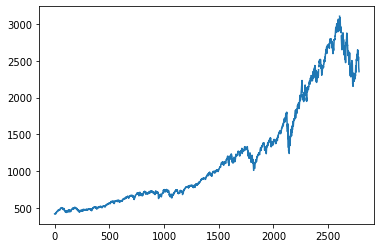

In [133]:
# Plotting the features that make sense to plot to get a general feel for the shape/trend of each
def plotFeature(feature):
    df[feature].plot()
#Feature1: very sporadic, no real trend as far as I can tell
#Feature2: Not a lot of unique data, everything in 90-100 range over time, jumps up and down
#Feature5: somewhat linear looking, kinda looks like a stock price of some sort
#Feature6: somewhat linear in the same sense as feature5, but concave upish instead of 5's concave down
#Feature7: very sporadic, similar trend by the looks of it to feature6
#Feature8: very similar to feature5 by the looks of it
#Target:has an exponential looking trend to it, closest to feature6 by the looks of it
plotFeature('Target')

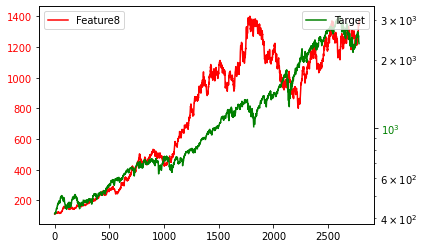

In [134]:
'''TEMP PLOT CODE'''
fig, ax = plt.subplots()
ax.plot(df['Feature8'], label = 'Feature8', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax2 = ax.twinx()
ax2.plot(df['Target'],label='Target', color='green')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='green')
ax.legend()
ax2.legend(loc = 'upper right')

In [135]:
'''For feature 7 and target, since the data is moving forward in time, will fill any missing gaps
with with the mean of the values in-between, and since the first row is NaN will put in the value '''
df['Feature7']=df['Feature7'].interpolate(method='linear', limit_direction ='forward')
df['Target']=df['Target'].interpolate(method='linear', limit_direction ='forward')
df.at[0,'Feature7'] = df.at[1,'Feature7']
df.at[0,'Target'] = df.at[1,'Target']

'''Looking through the CSV file for Feature 4, there are only specific values on specific days to start,
which may indicate that feature is used for notifying if there was a major spike or dip in the market. 
Starting on 3/30/2015, that feature is full of 7s. So to compensate for the many days at the start where
there are no values, will fill these NaN values with a 1 to act as a dummy value so the rest of that feature
doesn't have to get thrown out over it. I have a hunch that feature is used as a very specific marker for the trend,
so as of now I would hate to have to throw out the feature.'''
df['Feature4']=df['Feature4'].replace(np.nan,1)
df.isna().sum()

Feature1    0
Feature2    0
Feature3    0
Feature4    0
Feature5    0
Feature6    0
Feature7    0
Feature8    0
Target      0
dtype: int64

In [136]:
# Make correlation matrix to see which features are most correlated with the target
corr = df.corr()['Target']
print(corr)
'''From here, can see that we want Features3-8 since they all feature a high correlation
while the other features either have a small correlation(1) or negative(2)'''
# df.drop(['Feature1','Feature2'],axis=1)
#TEST
df.drop(['Feature6','Feature1','Feature2'],axis=1)
# df.drop(['Feature6'],axis=1)

Feature1    0.111473
Feature2   -0.030980
Feature3    0.960788
Feature4    0.409481
Feature5    0.747800
Feature6    0.991483
Feature7    0.926291
Feature8    0.782104
Target      1.000000
Name: Target, dtype: float64


,Feature3,Feature4,Feature5,Feature7,Feature8,Target
0,189.51,1.0,13.98,13.4953,111.226153,416.83
1,189.48,1.0,13.99,13.4953,111.721437,416.83
2,189.48,1.0,13.99,13.5303,111.272202,417.91
3,189.48,1.0,13.99,13.5992,114.116897,420.04
4,189.48,1.0,13.99,13.6141,113.592208,420.50
...,...,...,...,...,...,...
2779,426.86,7.0,26.83,25.8568,1339.113903,2444.95
2780,426.86,7.0,26.83,25.5268,1349.338215,2413.74
2781,426.86,7.0,26.83,25.2514,1354.650743,2387.70
2782,426.86,7.0,26.83,25.0084,1375.527183,2364.72


In [137]:
#Normalize data, split data between training and testing (75/25)
train=df.sample(frac=0.75,random_state=42) #random state is a seed value
test=df.drop(train.index)
#checking that they add up
print(df.shape[0])
print(train.shape[0])
print(test.shape[0])
xTrain = train.loc[:,train.columns != 'Target'].values  
yTrain = train.loc[:,train.columns == 'Target'].values
# xTrain = np.log(train.loc[:,train.columns != 'Target'].values)  

# yTrain = np.log(train.loc[:,train.columns == 'Target'].values)
xTest  = test.loc[:,test.columns != 'Target'].values 
yTest = test.loc[:,test.columns == 'Target'].values
# xTest  = np.log(test.loc[:,test.columns != 'Target'].values) 

# yTest = np.log(test.loc[:,test.columns == 'Target'].values)

print('Done splitting data')
#Need to normalize data to prevent overly large values from skewing the results
xTrainNormalized = xTrain / np.linalg.norm(xTrain)
yTrainNormalized = yTrain / np.linalg.norm(yTrain)
xTestNormalized = xTest / np.linalg.norm(xTest)
yTestNormalized = yTest / np.linalg.norm(yTest)
print('Done normalizing data')

2784
2088
696
Done splitting data
Done normalizing data


Part 1: Linear Regression Model

Because we are unsure about which features should have the strongest weighting and are the most significant to the regression, the regression should be made as a form of a stepwise regression to pick which features give the best results.

References for understanding the concepts:
https://www.investopedia.com/terms/s/stepwise-regression.asp
https://machinelearningcompass.com/machine_learning_models/ridge_regression/
https://machinelearningcompass.com/machine_learning_models/lasso_regression/

References for learning how to code them (aka not just importing the model from a package):
https://euanrussano.github.io/20190810linearRegressionNumpy/

In [138]:
# Initialize starting set of parameters 
theta0 = np.zeros((xTrainNormalized.shape[1],1))+5

# calculate gradient
def grad(theta):
    dJ = 1/len(xTrain)*np.sum((xTrainNormalized.dot(theta)-yTrainNormalized)*xTrainNormalized,axis=0).reshape(-1,1)
    return dJ


In [139]:
# cost function
def cost(theta):
    J = np.sum((xTrainNormalized.dot(theta)-yTrainNormalized)**2,axis=0)[0]
    return J

In [140]:
def GD(theta0,learning_rate = 0.5,epochs=100000,TOL=1e-7):
    
    theta_history = [theta0]
    J_history = [cost(theta0)]
    
    thetanew = theta0*10000
    print(f'epoch \t Cost(J) \t')
    for epoch in range(epochs):
        if epoch%100 == 0:
            print(f'{epoch:5d}\t{J_history[-1]:7.4f}\t')
        dJ = grad(theta0)
        J = cost(theta0)
        
        thetanew = theta0 - learning_rate*dJ
        theta_history.append(thetanew)
        J_history.append(J)
        if np.sum((thetanew - theta0)**2) < TOL:
            print('Convergence achieved.')
            break
        theta0 = thetanew

    return thetanew,theta_history,J_history


In [141]:
theta,theta_history,J_history = GD(theta0)

epoch 	 Cost(J) 	
    0	16.0768	
  100	15.3329	
  200	14.6164	
  300	13.9335	
  400	13.2825	
  500	12.6619	
  600	12.0703	
  700	11.5065	
  800	10.9689	
  900	10.4566	
 1000	 9.9682	
 1100	 9.5026	
 1200	 9.0588	
 1300	 8.6358	
 1400	 8.2325	
 1500	 7.8481	
 1600	 7.4817	
 1700	 7.1324	
 1800	 6.7995	
 1900	 6.4821	
 2000	 6.1796	
 2100	 5.8912	
 2200	 5.6163	
 2300	 5.3543	
 2400	 5.1045	
 2500	 4.8664	
 2600	 4.6395	
 2700	 4.4231	
 2800	 4.2169	
 2900	 4.0203	
 3000	 3.8329	
 3100	 3.6543	
 3200	 3.4840	
 3300	 3.3217	
 3400	 3.1670	
 3500	 3.0195	
 3600	 2.8789	
 3700	 2.7449	
 3800	 2.6172	
 3900	 2.4954	
 4000	 2.3794	
 4100	 2.2687	
 4200	 2.1632	
 4300	 2.0627	
 4400	 1.9669	
 4500	 1.8755	
 4600	 1.7884	
Convergence achieved.


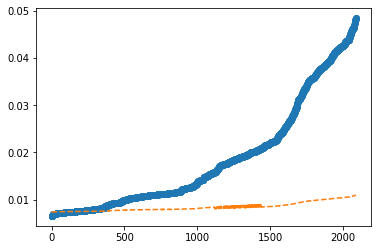

In [142]:
yprednorm = xTrainNormalized.dot(theta)
maxy, miny = np.max(yTrainNormalized), np.min(yTrainNormalized)
ypred = yprednorm*(maxy-miny) + miny
sortidx = np.argsort(yTrainNormalized[:,0])
plt.plot(yTrainNormalized[sortidx,0],'o')
plt.plot(ypred[sortidx,0],'--')


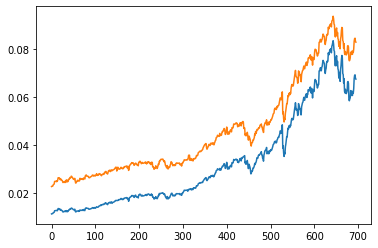

In [143]:
#comparison to sklearn pre-trained LinearRegression model
from sklearn.linear_model import LinearRegression
testModel = LinearRegression()
testModel.fit(xTrainNormalized, yTrainNormalized)
yPred = testModel.predict(xTestNormalized)
plt.plot(yTestNormalized)
plt.plot(yPred)

Part 2: Training any ML model on the data

For this part of the problem, I opted to using a polynomial regression on the data (using the same data that was preprocessed and split for the first part). I decided to utilize a polynomial regression since when I looked at the graph of the target column (in the code cell of my code where the different feature or target columns can be plotted), it reminded me of a very wide looking parabola. For this reason, I decided to utilize sklearn's PolynomialFeatures class to generate a "polynomial" version of the features that would then be passed in the linear regression model to do the polynomial regression. In the end, this worked very well, achieving a MSE of around 0.00024557, indicating a successful model that is also relatively lightweight computation-wise in comparison to training a neural network or something more complicated.

In [144]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

bestDegree = 0
bestMSE = 9999999999
degrees = [2,3,4,5]
'''To determine what degree polynomial works the best, I decided to iterate over different possible values for the degree of the polynomial,
    and the polynomial degree that achieved the lowest MSE is the one that was saved to be re-trained as the final model.'''
for degreeVal in degrees:
    model = Pipeline([('poly', PolynomialFeatures(degree=degreeVal)),('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(xTrainNormalized, yTrainNormalized)
    preds = model.predict(xTestNormalized)
    currentMSE = mean_squared_error(yTestNormalized, preds)
    if  currentMSE < bestMSE:
        bestMSE = currentMSE
        bestDegree = degreeVal
model = Pipeline([('poly', PolynomialFeatures(degree=bestDegree)),('linear', LinearRegression(fit_intercept=False))])
model = model.fit(xTrainNormalized, yTrainNormalized)
preds = model.predict(xTestNormalized)
print('Best degree for polynomial regression: ',bestDegree)
print('MSE for regression with the best degree: ',mean_squared_error(yTestNormalized, preds))

Best degree for polynomial regression:  2
MSE for regression with the best degree:  0.0002455703642003869
